In [1]:
import tensorflow.keras
import numpy as np
import tensorflow as tf

2024-04-10 20:30:12.140954: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 20:30:12.198535: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 20:30:13.113840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
BINARY_SIZE = 1
PATCH_SIZE = 8
BATCH_SIZE = 256

In [3]:
def load_dataset(dataset_name):
    import keras.datasets as datasets
    (x_train, _), (x_test, _) = getattr(datasets, dataset_name).load_data()

    x_train = np.append(x_train, x_test, axis=0)
    x_train = x_train.astype('float32') / 127.5 - 1
    return x_train

def get_data():
    cifar10_dataset = load_dataset('cifar10')
    cifar100_dataset = load_dataset('cifar100')
    stl10_dataset = load_dataset('stl10')

    # append the datasets
    dataset = np.append(cifar10_dataset, cifar100_dataset, axis=0)
    dataset = np.append(dataset, stl10_dataset, axis=0)
    
    return dataset

def get_simple_data():
    cifar10_dataset = load_dataset('cifar10')

    return cifar10_dataset

In [4]:
dataset = get_simple_data()

In [5]:
dataset.shape

(60000, 32, 32, 3)

In [6]:
dataset = tf.image.extract_patches(dataset, sizes=[1, PATCH_SIZE, PATCH_SIZE, 1], strides=[1, PATCH_SIZE, PATCH_SIZE, 1], rates=[1, 1, 1, 1], padding='VALID')

2024-04-10 20:30:15.364765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-10 20:30:15.422348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-10 20:30:15.422389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-10 20:30:15.426279: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-10 20:30:15.426345: I tensorflow/compile

In [7]:
dataset = tf.reshape(dataset, [-1, PATCH_SIZE, PATCH_SIZE, 3])

In [8]:
image_input = tensorflow.keras.layers.Input(shape=(PATCH_SIZE, PATCH_SIZE, 3))
x = tensorflow.keras.layers.Conv2D(32, (3, 3), activation='tanh', padding='same')(image_input)
x = tensorflow.keras.layers.AveragePooling2D((2, 2), padding='same')(x)
x = tensorflow.keras.layers.Dropout(0.2)(x)
x = tensorflow.keras.layers.Conv2D(64, (3, 3), activation='tanh', padding='same')(x)
x = tensorflow.keras.layers.AveragePooling2D((2, 2), padding='same')(x)
x = tensorflow.keras.layers.Conv2D(128, (3, 3), activation='tanh', padding='same')(x)
x= tensorflow.keras.layers.AveragePooling2D((2, 2), padding='same')(x)
x = tensorflow.keras.layers.Conv2D(BINARY_SIZE, (3, 3), activation='tanh', padding='same')(x)
encoded = tensorflow.keras.layers.AveragePooling2D((2, 2), padding='same', name='encoded_out')(x)

x = tensorflow.keras.layers.Conv2D(128, (3, 3), activation='tanh', padding='same')(encoded)
x = tensorflow.keras.layers.UpSampling2D((2, 2))(x)
x = tensorflow.keras.layers.Dropout(0.2)(x)
x = tensorflow.keras.layers.Conv2D(64, (3, 3), activation='tanh', padding='same')(x)
x = tensorflow.keras.layers.UpSampling2D((2, 2))(x)
x = tensorflow.keras.layers.Dropout(0.2)(x)
x = tensorflow.keras.layers.Conv2D(32, (3, 3), activation='tanh', padding='same')(x)
x = tensorflow.keras.layers.UpSampling2D((2, 2))(x)
x = tensorflow.keras.layers.Dropout(0.2)(x)
decoded = tensorflow.keras.layers.Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

autoencoder = tensorflow.keras.Model(image_input, decoded)
autoencoder.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()

autoencoder.fit(dataset, dataset, epochs=10, batch_size=BATCH_SIZE, shuffle=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 8, 3)]         0         
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 32)          896       
                                                                 
 average_pooling2d (AverageP  (None, 4, 4, 32)         0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 4, 4, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 2, 2, 64)         0         
 ePooling2D)                                                 

2024-04-10 20:30:17.724233: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-10 20:30:17.941200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907
2024-04-10 20:30:18.193013: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-10 20:30:20.012270: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f5d40f93eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-10 20:30:20.012314: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-04-10 20:30:20.049097: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash re

3750/3750 [==============================] - 29s 6ms/step - loss: 0.1043
Epoch 2/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.1036
Epoch 3/10
3750/3750 [==============================] - 24s 6ms/step - loss: 0.1036
Epoch 4/10
3750/3750 [==============================] - 24s 6ms/step - loss: 0.1033
Epoch 5/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.1030
Epoch 6/10
3750/3750 [==============================] - 24s 6ms/step - loss: 0.1030
Epoch 7/10
3750/3750 [==============================] - 25s 7ms/step - loss: 0.1030
Epoch 8/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.1030
Epoch 9/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.1030
Epoch 10/10
3750/3750 [==============================] - 23s 6ms/step - loss: 0.1030


In [9]:
def pad_image(image: np.ndarray, patch_size: int):
    h, w, c = image.shape
    h_pad = (patch_size - (h % patch_size)) % patch_size
    w_pad = (patch_size - (w % patch_size)) % patch_size

    return np.pad(image, ((0, h_pad), (0, w_pad), (0, 0)), mode='constant', constant_values=0), h_pad, w_pad

In [10]:
def compress_image(image: np.ndarray, network: tf.keras.Model) -> tuple[np.ndarray, np.ndarray]:
    """
    Compress an image using the given network
    :param image: The image to compress
    :param network: The network to use for compression
    :return: The compressed image & the bits
    """
    patch_size = PATCH_SIZE

    # pad the image
    image, h_pad, w_pad = pad_image(image, patch_size)
    
    height, width, channels = image.shape
    no_patches_width = width // patch_size
    no_patches_height = height // patch_size
    
    # transform image to list with a single element
    image = tf.expand_dims(image, axis=0)

    image = tf.image.extract_patches(image, sizes=[1, patch_size, patch_size, 1], strides=[1, patch_size, patch_size, 1], rates=[1, 1, 1, 1], padding='VALID')
    image = tf.divide(tf.cast(image, tf.float32), 127.5) - 1
    image = tf.reshape(image, [-1, patch_size,patch_size,3])

    reconstructed_patches = network.predict(image)
    reconstructed_image = np.zeros((height, width, channels))

    for i in range(no_patches_height):
        for j in range(no_patches_width):
            patch = reconstructed_patches[i*no_patches_width+j].reshape(patch_size, patch_size, 3)
            # print(i*patch_size, (i+1)*patch_size, j*patch_size, (j+1)*patch_size)
            reconstructed_image[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = patch

    height = height - h_pad
    width = width - w_pad

    reconstructed_image = reconstructed_image[:height, :width]
    reconstructed_image = (reconstructed_image + 1) * 127.5
    reconstructed_image = reconstructed_image.astype(np.uint8)

    return reconstructed_image

In [11]:
image = tf.image.decode_image(tf.io.read_file('ciob.png'), channels=3)

reconstructed_image_32 = compress_image(image, autoencoder)

93/93 [==============================] - 1s 7ms/step


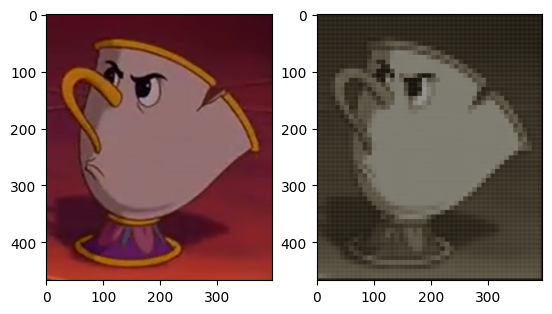

In [12]:
import matplotlib.pyplot as plt

ax, fig = plt.subplots(1, 2)
fig[0].imshow(image)
fig[1].imshow(reconstructed_image_32)

In [13]:
# compute psnr
tf.image.psnr(image, reconstructed_image_32, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=18.611115>

In [14]:
tf.image.ssim(image, reconstructed_image_32, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.67323226>

In [15]:
tf.image.ssim_multiscale(image, reconstructed_image_32, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.82857823>

In [16]:
encoder = tensorflow.keras.Model(image_input, encoded)

In [17]:
image_, _, _ = pad_image(image, PATCH_SIZE)
no_patches_width = image_.shape[1] // PATCH_SIZE
no_patches_height = image_.shape[0] // PATCH_SIZE

width = image_.shape[1]
height = image_.shape[0]

image_ = tf.expand_dims(image_, axis=0)
img_patches = tf.image.extract_patches(image_, sizes=[1, PATCH_SIZE, PATCH_SIZE, 1], strides=[1, PATCH_SIZE, PATCH_SIZE, 1], rates=[1, 1, 1, 1], padding='VALID')
img_patches = tf.reshape(img_patches, [-1, PATCH_SIZE, PATCH_SIZE, 3])

img_patches = tf.divide(tf.cast(img_patches, tf.float32), 127.5) - 1

encoded_patches = encoder.predict(img_patches)

93/93 [==============================] - 0s 1ms/step


In [18]:
encoded_patches = encoded_patches.astype(np.float16)
encoded_patches.shape

(2950, 1, 1, 1)

In [19]:
decoder_input = tensorflow.keras.layers.Input(shape=(1, 1, 64))
decoder = tensorflow.keras.Model(encoded, decoded)

rec = decoder.predict(encoded_patches)

93/93 [==============================] - 0s 2ms/step


In [20]:
reconstructed_image_16 = np.zeros((height, width, 3))

for i in range(no_patches_height):
    for j in range(no_patches_width):
        patch = rec[i*no_patches_width+j].reshape(PATCH_SIZE, PATCH_SIZE, 3)
        reconstructed_image_16[i*PATCH_SIZE:(i+1)*PATCH_SIZE, j*PATCH_SIZE:(j+1)*PATCH_SIZE] = patch

reconstructed_image_16 = (reconstructed_image_16 + 1) * 127.5
reconstructed_image_16 = reconstructed_image_16[:image.shape[0], :image.shape[1]]


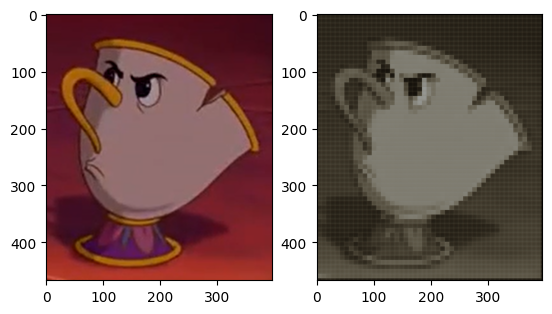

In [21]:
import matplotlib.pyplot as plt

ax, fig = plt.subplots(1, 2)
fig[0].imshow(image)
fig[1].imshow(reconstructed_image_16.astype(np.uint8))

In [22]:
tf.image.psnr(image, reconstructed_image_16.astype(np.uint8), max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=18.611202>

In [23]:
tf.image.ssim(image, reconstructed_image_16.astype(np.uint8), max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.67322737>

In [24]:
tf.image.ssim_multiscale(image, reconstructed_image_16.astype(np.uint8), max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8285699>

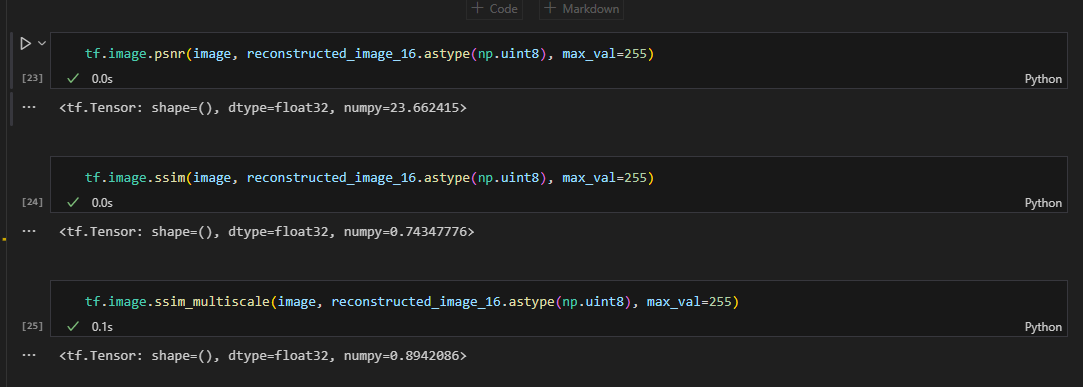